# 2. Data exploration

In the previous notebook, two types of data were loaded to a PostGIS database called 'bcn_traffic':

1. Monthly traffic report of different street sections of Barcelona
2. Geometries of street sections of Barcelona

-------------------------

**Field information:**

1. Monthly traffic report
   * sectionID: Section identification number

   * time: Date & time of registration (format: YYYY-MM-DD)

   * current_flow: Current traffic flow(0 = sense dades / 1 = molt fluid / 2 = fluid / 3 = dens / 4 = molt dens / 5 = congestió / 6 = tallat)

   * estimated_flow: Estimated traffic flow after 15min (0 = sense dades / 1 = molt fluid / 2 = fluid / 3 = dens / 4 = molt dens / 5 = congestió / 6 = tallat)


2. Geometries (each traffic section)
   * Tram = sectionID
   * Tram_Components: Different points within the same section	
   * Descripció: Description of the 
   * Longitud: Longitude
   * Latitud: Latitude

In [1]:
# Import libraries
import db # db.py
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')
sns.despine()
sns.set_context(rc={'axes.labelsize':18,
                    'axes.titlesize':18,
                    'font.size':15,
                    'legend.fontsize':15,
                    'lines.linewidth':2.2})

<Figure size 432x288 with 0 Axes>

In [2]:
# Get all names of tables exist in our database
table_names = db.get_table_names()
table_names

[('spatial_ref_sys',),
 ('gener2019',),
 ('febrer2019',),
 ('marc2019',),
 ('abril2019',),
 ('maig2019',),
 ('juny2019',),
 ('juliol2019',),
 ('agost2019',),
 ('setembre2019',),
 ('octubre2019',),
 ('novembre2019',),
 ('desembre2019',),
 ('gener2020',),
 ('febrer2020',),
 ('marc2020',),
 ('abril2020',),
 ('maig2020',),
 ('juny2020',),
 ('juliol2020',),
 ('agost2020',),
 ('setembre2020',),
 ('octubre2020',),
 ('section_geom',)]

In [3]:
# Select tables containing monthly traffic flow info
monthly_tables = [','.join(name) for name in table_names][1:-1]
monthly_tables

['gener2019',
 'febrer2019',
 'marc2019',
 'abril2019',
 'maig2019',
 'juny2019',
 'juliol2019',
 'agost2019',
 'setembre2019',
 'octubre2019',
 'novembre2019',
 'desembre2019',
 'gener2020',
 'febrer2020',
 'marc2020',
 'abril2020',
 'maig2020',
 'juny2020',
 'juliol2020',
 'agost2020',
 'setembre2020',
 'octubre2020']

In [6]:
# Let's compare September's traffic in 2019 and 2020

# Names of tables containing data from month of september
septembers = ['setembre2019', 'setembre2020']

# New dataframe names
df_sep = pd.DataFrame()

In [7]:
# Query to select data from tables
# Filter if the current traffic flow data exists (value 1-6)
    
for i in range(2):
    query = f"""
            select * from {septembers[i]}
            where current_flow <> 0 and estimated_flow <>0
            """
    # Predifine column names
    column_names = ['sectionID', 'time', 'current_flow', 'estimated_flow']

    # Create dataframe
    result = db.db_to_df(query, column_names)
    df_sep = df_sep.append(result)

print(df_sep.shape)
df_sep.head()

(4561849, 4)


,sectionID,time,current_flow,estimated_flow
0,112,20190901000054,1,5
1,142,20190901000054,2,5
2,157,20190901000054,2,5
3,158,20190901000054,2,5
4,170,20190901000054,1,5


In [8]:
# Check if the data has corrupted points:
# 1. empty rows
# 2. duplicated data
print(f'Proportion of empty rows?: {df_sep.isnull().any().mean()}')
print(f'Proportion of duplicated rows?: {df_sep.duplicated().mean()}')

Proportion of empty rows?: 0.0
Proportion of duplicated rows?: 0.0


In [9]:
# How many unique sectionIDs are there?
len(df_sep['sectionID'].unique())

423

In [10]:
# Print data types
df_sep.dtypes

sectionID         int64
time              int64
current_flow      int64
estimated_flow    int64
dtype: object

In [11]:
# Convert datatype of 'time' column
df_sep['time'] = pd.to_datetime(df_sep['time'].astype(str), yearfirst=True)

print(df_sep['time'].dtype)
df_sep.head()

datetime64[ns]


,sectionID,time,current_flow,estimated_flow
0,112,2019-09-01 00:00:54,1,5
1,142,2019-09-01 00:00:54,2,5
2,157,2019-09-01 00:00:54,2,5
3,158,2019-09-01 00:00:54,2,5
4,170,2019-09-01 00:00:54,1,5


In [12]:
# Check the change in dtypes and summary info
df_sep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4561849 entries, 0 to 2294552
Data columns (total 4 columns):
 #   Column          Dtype         
---  ------          -----         
 0   sectionID       int64         
 1   time            datetime64[ns]
 2   current_flow    int64         
 3   estimated_flow  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 174.0 MB


In [13]:
#1. Split 'time' column into year, month, date
df_sep['year'] = df_sep.time.dt.year
df_sep['month'] = df_sep.time.dt.month
df_sep['day'] = df_sep.time.dt.day

#2. Add day of the week:
df_sep['weekday'] = df_sep.time.dt.day_name()

# Print the first 5 rows
df_sep.head()

,sectionID,time,current_flow,estimated_flow,year,month,day,weekday
0,112,2019-09-01 00:00:54,1,5,2019,9,1,Sunday
1,142,2019-09-01 00:00:54,2,5,2019,9,1,Sunday
2,157,2019-09-01 00:00:54,2,5,2019,9,1,Sunday
3,158,2019-09-01 00:00:54,2,5,2019,9,1,Sunday
4,170,2019-09-01 00:00:54,1,5,2019,9,1,Sunday


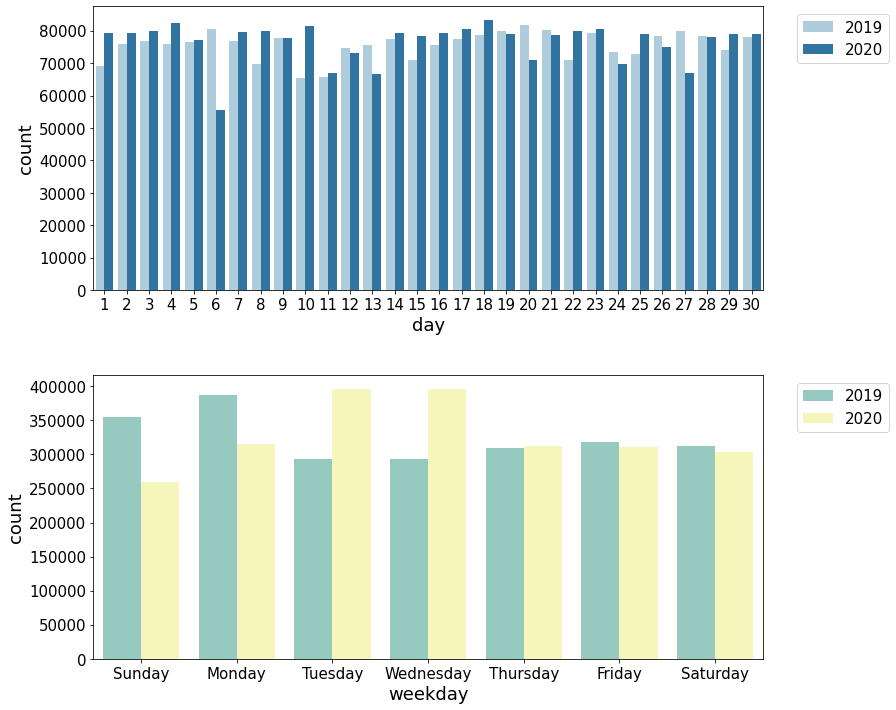

In [14]:
# Plot observation counts per day and weekday
fig, ax = plt.subplots(2, 1, figsize=(12,12))
plt.subplots_adjust(hspace=.3)

ax1 = sns.countplot(df_sep['day'], palette='Paired', ax=ax[0], hue=df_sep['year'])
ax1.legend(bbox_to_anchor=(1.2, 1), loc='upper right')

ax2 = sns.countplot(df_sep['weekday'], palette='Set3', ax=ax[1], hue=df_sep['year'])
ax2.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
plt.show()

In [22]:
# Any distinctively large difference of the two yers?
# Definitely check on 6th, 10th, and 27th // Sun-Wednesday inversion

sep_2019 = df_sep[df_sep.year == 2019]
sep_2020 = df_sep[df_sep.year == 2020]

sep_differences = sep_2020.groupby('day').count() - sep_2019.groupby('day').count()
sep_differences.head()

,sectionID,time,current_flow,estimated_flow,year,month,weekday
day,,,,,,,
1,10374,10374,10374,10374,10374,10374,10374
2,3288,3288,3288,3288,3288,3288,3288
3,3150,3150,3150,3150,3150,3150,3150
4,6314,6314,6314,6314,6314,6314,6314
5,524,524,524,524,524,524,524


In [14]:
# Traffic state by weekday
traffic_by_weekday = pd.DataFrame(df_sep.groupby('current_flow')['weekday'].value_counts())
traffic_by_weekday.columns = ['counts']
traffic_by_weekday.reset_index(inplace=True)
traffic_by_weekday.head(6)

,current_flow,weekday,counts
0,1,Sunday,355889
1,1,Saturday,300966
2,1,Tuesday,220487
3,1,Wednesday,216923
4,1,Monday,206361
5,1,Friday,201791


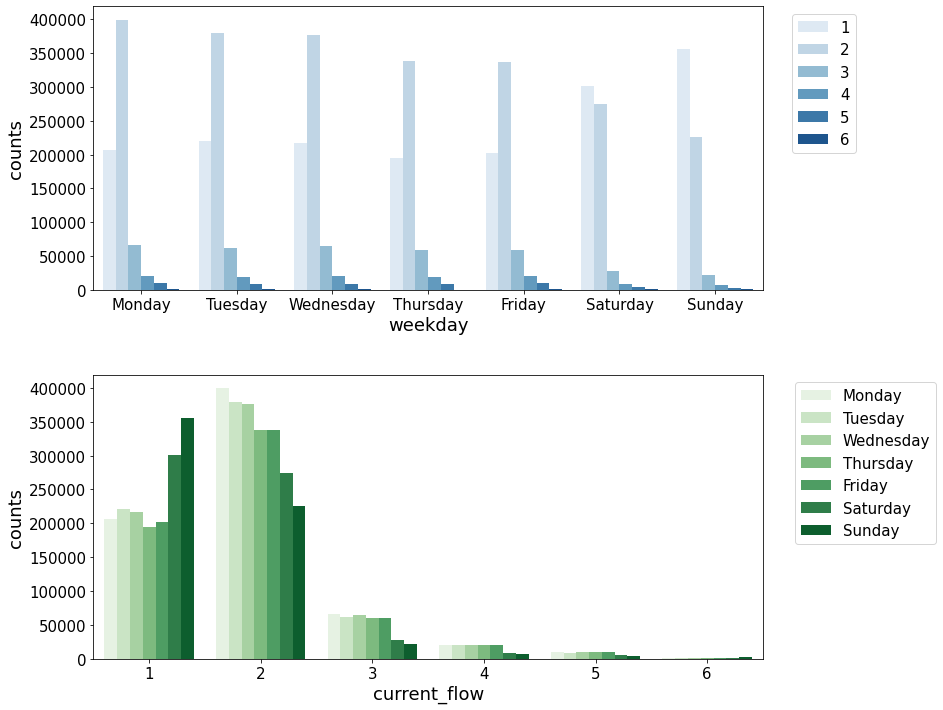

In [15]:
# Plot traffic state by weekday
fig, ax = plt.subplots(2, 1, figsize=(12,12))
plt.subplots_adjust(hspace=.3)

order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ax1 = sns.barplot(x='weekday', y='counts',
                  data=traffic_by_weekday,
                  order=order_of_days,
                  hue='current_flow',
                  palette='Blues',
                  ax=ax[0])
ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper right')

ax2 = sns.barplot(x='current_flow', y='counts',
                  data=traffic_by_weekday,
                  hue_order=order_of_days,
                  hue='weekday',
                  palette='Greens',
                  ax=ax[1])
ax2.legend(bbox_to_anchor=(1.27, 1), loc='upper right')

plt.show()

In [ ]:
# Sections with the most fluid and most heavy traffic in average

# Select 10 and analyze traffic of these sections using diff datetime variables

In [ ]:
# Integrate more geodata retrieved from QGIS

### Let's integrate geometry and visualize important traffic sections

In [16]:
# Load geometry file
query = '''
        select *, ST_SetSRID(ST_MakePoint(longitude, latitude), 4326) as geometry
        from section_geom
        '''

bcn_geom = db.db_to_gdf(query, 'geometry')
bcn_geom.head()

,sectionID,section_components,description,longitude,latitude,geometry
index,,,,,,
0,1,1,Diagonal (Ronda de Dalt a Doctor Marañón),2.112035,41.384191,POINT (2.11204 41.38419)
1,1,2,Diagonal (Ronda de Dalt a Doctor Marañón),2.101503,41.381631,POINT (2.10150 41.38163)
2,2,1,Diagonal (Doctor Marañón a Ronda de Dalt),2.111944,41.384467,POINT (2.11194 41.38447)
3,2,2,Diagonal (Doctor Marañón a Ronda de Dalt),2.101594,41.381868,POINT (2.10159 41.38187)
4,3,1,Diagonal (Doctor Marañón a Pl. Pius XII),2.112093,41.384229,POINT (2.11209 41.38423)


In [17]:
# Gather all the points from each sectionID
# And convert the geometry to a line (LineString)
to_linestring = bcn_geom.groupby('sectionID').geometry.apply(lambda x: LineString(x.tolist()))

# Result as a geodataframe
bcn_geom_2 = gpd.GeoDataFrame(to_linestring, crs=4326)
print(bcn_geom_2.crs)
print(bcn_geom_2.shape)
bcn_geom_2.head()

epsg:4326
(492, 1)


,geometry
sectionID,
1,"LINESTRING (2.11204 41.38419, 2.10150 41.38163)"
2,"LINESTRING (2.11194 41.38447, 2.10159 41.38187)"
3,"LINESTRING (2.11209 41.38423, 2.12265 41.38693)"
4,"LINESTRING (2.12259 41.38719, 2.11197 41.38446)"
5,"LINESTRING (2.12266 41.38694, 2.12756 41.38818)"


In [18]:
# Check if the data has corrupted points:
# 1. empty rows
# 2. duplicated data
print(f'Proportion of empty rows?: {bcn_geom_2.isnull().any().mean()}')
print(f'Proportion of duplicated rows?: {bcn_geom_2.duplicated().mean()}')

Proportion of empty rows?: 0.0
Proportion of duplicated rows?: 0.0


In [19]:
# Print the current CRS (Coordinate Reference System)
print(f'Before: {bcn_geom_2.crs}')

# Reproject data in Web mercator
bcn_geom_2 = bcn_geom_2.to_crs(epsg=3857)
print(f'After: {bcn_geom_2.crs}')

Before: epsg:4326
After: epsg:3857


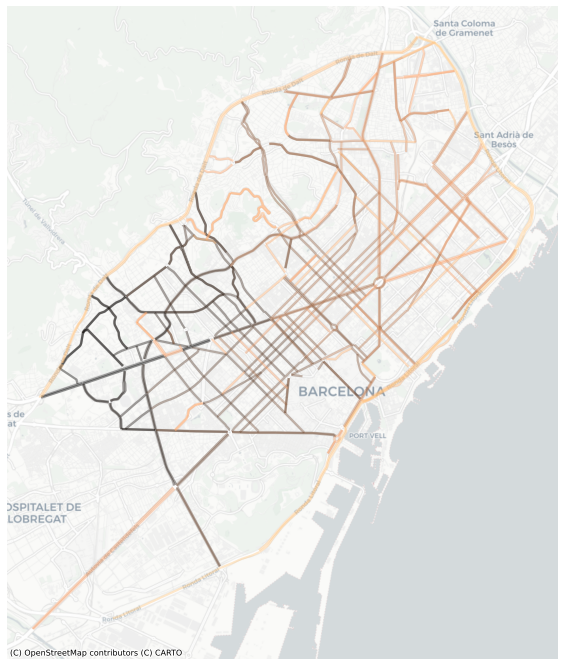

In [20]:
# Visualize the secion geomtry

# Plot the traffic sections (LineStrings)
ax = bcn_geom_2.plot(figsize=(12, 12), alpha=.4, cmap='copper')

# Basemap of BCN city
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.show()

In [ ]:
# Plot 10 sections with the most fluid & heavy traffic in 2019 and 2020

In [21]:
# Add more geodata (+ demographic data if possible)

In [22]:
# More exploration, correlation between variables?

In [23]:
# Feature engineering

In [ ]:
# Baseline model